# 6. Investigating the impact of warming on model predictions
## Forecasting Crop Yields on a national scale (FACYnation)

### by Raphael Shirley (University of Sussex)

In this notebook we take the previous model and investigate increases in temperature.

## Investigating impact of temperature increases

In this notebook we take the two dimensional Gaussian fitted to the regional data and check for the impact of temperature increases which should depend on where current temperatures lie with respect to the peak yield response.









## Rerun model from notebook 3
First lets generate the same set of samples from the posterior.

In [13]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline


In [14]:
# Read in climate temperatures
clim_temp_maize=pd.read_table('./Crop_data_files/clim_file/temp_climatology_Maize.csv')
clim_temp_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)
# Read in climate precipitation
clim_precip_maize=pd.read_table('./Crop_data_files/clim_file/precip_climatology_Maize.csv')
clim_precip_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)
# Read in Yields
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [15]:
states=['Indiana','Illinois', 'Ohio','Nebraska', 'Iowa','Minnesota']

In [16]:
#Read in and add back mean temperature to get real temperature values
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_temp.iloc[:,1:].add(clim_temp_maize[clim_temp_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    temp_states.append(tmp)
temp_states=pd.concat(temp_states,keys=states)

#Read in and add back mean precipitation to get real precipitation values
precip_states=[]
for i,s in enumerate(states):
    maize_precip=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_precip_anom_real.csv')
    maize_precip.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_precip.iloc[:,1:].add(clim_precip_maize[clim_precip_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    precip_states.append(tmp)
precip_states=pd.concat(precip_states,keys=states)

In [17]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data2={
    'n_regions':len(states),
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,3:9]).reshape(
                     len(states),
                     np.int(np.array(temp_states.iloc[:,3:9]).shape[0]/len(states)),6
                                                      ).astype(float),
    'd_precip':np.array(precip_states.iloc[:,3:9]).reshape(
                     len(states),
                     np.int(np.array(precip_states.iloc[:,3:9]).shape[0]/len(states)),6
                                                      ).astype(float),
    'd_yields':np.array(yields[yields["Region"].isin(
                     ['Maize_Spring_USA_'+s for s in states]
                                                    )].iloc[:,22:]).astype(float)+6,
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)

}

In [18]:

gm2 = pystan.StanModel(file='./stan/2d-gaussian.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_889b1084947e1d379c9ef129719d74d2 NOW.


In [19]:

fit=gm2.sampling(data=data2,chains=4,iter=1000,verbose=True,seed=1308)

In [20]:

fit

Inference for Stan model: anon_model_889b1084947e1d379c9ef129719d74d2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t               19.71    0.02   0.68  18.17  19.29  19.77  20.19  20.87   1205    1.0
sigma_t             5.23    0.02   0.58   4.26    4.8   5.17    5.6   6.49    795    1.0
mu_p              114.69    0.11   4.26 106.07 111.81 114.87 117.65 122.71   1571    1.0
sigma_p            62.41    0.07   2.76  57.16  60.51  62.41  64.24   67.9   1633    1.0
norm                1.56  2.3e-3   0.07   1.43   1.51   1.56    1.6    1.7    862    1.0
fdy1[0]           3.5e-3  2.4e-4 6.8e-3 1.8e-5 2.6e-4 1.0e-3 3.5e-3   0.02    770    1.0
fdy1[1]           5.8e-3  3.7e-4   0.01 5.4e-5 6.1e-4 2.1e-3 6.5e-3   0.04    756    1.0
fdy1[2]           9.7e-3  5.4e-4   0.01 1.5e-4 1.4e-3 4.2e-3   0.01   0.05    746    1.0
fdy1[3]     

In [21]:

# carry out some diagnostic checks on fit
from xidplus.stan_fit import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [22]:
samples=fit.extract()

Text(0.5,1,'Growth Curve')

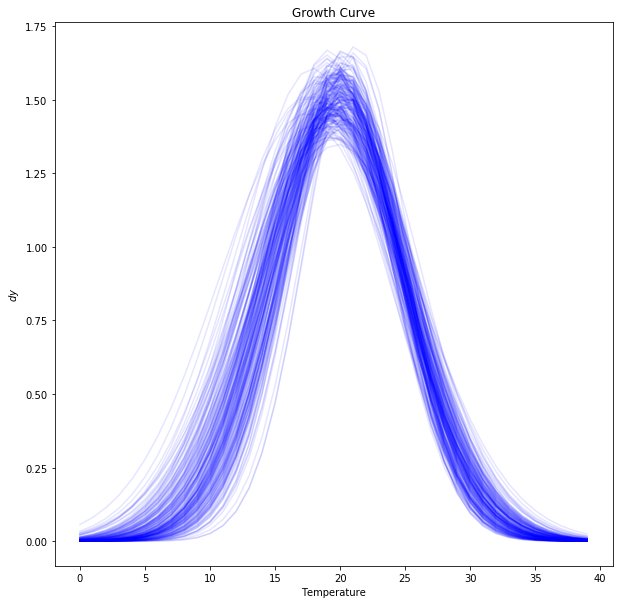

In [23]:
plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy1'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature')
plt.ylabel(r'$dy$')
plt.title('Growth Curve')

## Compute a sample of region averaged yield anomalies for each posterior sample

We have a sample from the posterior on the Gaussian parameters $\boldsymbol \theta_i$. For each sample, $i$, we want to compute the mean yield anomaly for all the regions combined at a given temperature increment $\Delta T_j$ applied to every tru temperature. After this procedure we will have a sample of mean yield anomalies $Y_i_j$ for each temperature increase.

In [67]:
a = 1.
a = np.array(a)
len(a)

TypeError: len() of unsized object

In [74]:
def yield_anomaly(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-0.5 *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                             + np.square((precip_6m[month] - mu_p)/sigma_p) )
                                      )
    return np.sum(dy)


def compute_mean_yield_anomaly(T_inc, data, mu_t, sigma_t, mu_p, sigma_p, norm):
    """ Compute mean yield anomaly for a model over regions and years
    
    The function yield_anomaly returens the yield anomaly for a year 
    and and region. Here we loop over the regions and years to create
    and overall mean.
    
    """
    
    yield_anomalies = np.zeros((6, 35))
    #loop over states
    for state in np.arange(6):
        #loop over years
        for year in np.arange(6):
            temp_6m = data['d_temp'][state, year, :] + T_inc
            precip_6m = data['d_precip'][state, year, :]
            yield_anomalies[state, year] = yield_anomaly(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, norm)
    
    return np.mean(yield_anomalies)


compute_mean_yield_anomaly(1., data2, 20., 5., 120., 65., [1.5])    

1.1550681176221087e-69

In [79]:
%%timeit
compute_mean_yield_anomaly(1., data2, 20., 5., 120., 65., [1.5]) 

2.95 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
200000* 2.95e-3

590.0

There are six regions each with 35 years with six months. We want the total average for each parameter set and temperature increase.

In [40]:
T_incs = np.linspace(0, 3, 100)

In [45]:
np.zeros((len(samples['mu_t']), len(T_incs))).shape

(2000, 100)

In [81]:
mean_yield_samples =  np.zeros((len(samples['mu_t']), len(T_incs)))

#Loop over the samples and for each parameter realisation

for n in np.arange(len(samples['mu_t'])):
    
    mu_t    = samples['mu_t'][n]
    sigma_t = samples['sigma_t'][n]
    mu_p    = samples['mu_p'][n]
    sigma_p = samples['sigma_p'][n]
    norm    = [samples['norm'][n]]
    for m, T_inc in enumerate(T_incs):
        mean_yield_samples[n, m] = compute_mean_yield_anomaly(T_inc, data2, mu_t, sigma_t, mu_p, sigma_p, norm)

In [97]:
len(mean_yield_samples.T[0])

2000

In [117]:
sample_means   = [np.mean(s) for s in mean_yield_samples.T]
sample_medians = [np.median(s) for s in mean_yield_samples.T]
sample_25      = [np.percentile(s, 25.) for s in mean_yield_samples.T]
sample_75      = [np.percentile(s, 75.)  for s in mean_yield_samples.T]

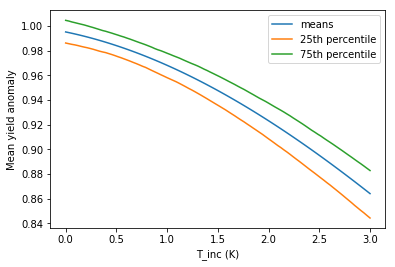

In [119]:
plt.plot(T_incs, sample_means, label='means')
#plt.plot(T_incs, sample_medians, label='medians')
plt.plot(T_incs, sample_25, label='25th percentile')
plt.plot(T_incs, sample_75, label='75th percentile')
plt.legend()
plt.xlabel('T_inc (K)')
plt.ylabel('Mean yield anomaly')
plt.savefig('temperature_impact.pdf')
plt.savefig('temperature_impact.png')

(array([   4.,    6.,   14.,   24.,   43.,   92.,  142.,  178.,  220.,
         230.,  248.,  221.,  189.,  162.,   86.,   71.,   38.,   17.,
           8.,    7.]),
 array([ 0.92262124,  0.92708509,  0.93154895,  0.9360128 ,  0.94047665,
         0.94494051,  0.94940436,  0.95386822,  0.95833207,  0.96279593,
         0.96725978,  0.97172363,  0.97618749,  0.98065134,  0.9851152 ,
         0.98957905,  0.99404291,  0.99850676,  1.00297061,  1.00743447,
         1.01189832]),
 <a list of 20 Patch objects>)

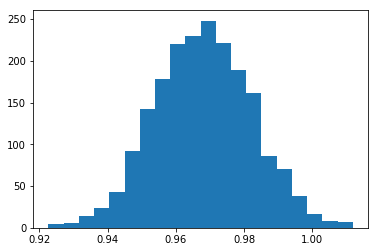

In [110]:
plt.hist(mean_yield_samples.T[33], 20)

(array([   4.,   12.,   22.,   40.,   88.,  114.,  155.,  216.,  231.,
         224.,  212.,  203.,  177.,  119.,   95.,   49.,   21.,   11.,
           5.,    2.]),
 array([ 0.95651682,  0.96056843,  0.96462004,  0.96867165,  0.97272326,
         0.97677488,  0.98082649,  0.9848781 ,  0.98892971,  0.99298132,
         0.99703293,  1.00108455,  1.00513616,  1.00918777,  1.01323938,
         1.01729099,  1.0213426 ,  1.02539422,  1.02944583,  1.03349744,
         1.03754905]),
 <a list of 20 Patch objects>)

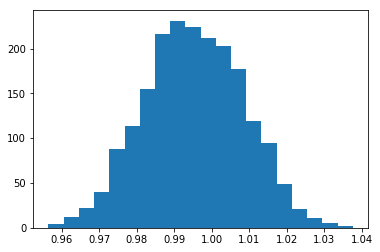

In [109]:
plt.hist(mean_yield_samples.T[0], 20)